In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
# Подсчитывает расстояние Хэмминга
def vector_dist(vect1, vect2):
    return np.sum(np.abs(vect1 - vect2))

# Перемножает матрицы в F2
def multiply_matrix(mat1, mat2):
    return np.mod(np.dot(mat1, mat2), 2)

# Получает все возможные двоичные вектора заданной длины
def generate_binary_vectors(vect_len):
    def get_all_vectors(vector_len, cur_vectors):
        if len(cur_vectors[0]) == vector_len: # если вектора уже нужного размера, возвращаем их
            return cur_vectors
        
        # в противном случае каждый вектор может быть продолжен двумя способами:
        # нулём и единицей
        new_vectors = []
        for cur_vector in cur_vectors:
            cur_vector_zero = cur_vector[:]
            cur_vector_zero.append(0)

            cur_vector_one = cur_vector[:]
            cur_vector_one.append(1)
            new_vectors.append(cur_vector_zero)
            new_vectors.append(cur_vector_one)
        return get_all_vectors(vector_len, new_vectors)
    
    answer = get_all_vectors(vect_len, [[]])
    assert len(answer) == 2 ** vect_len
    
    # оборачиваем в numpy-массивы для ускорения вычислений
    return np.array(answer)

In [3]:
# Порождающая матрица кода Голея
G = np.array(
    [
        [1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,1],
        [0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1],
        [0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1],
        [0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,1,1],
        [0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0],
        [0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0],
        [0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1],
        [0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0],
        [0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1,0],
        [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1],
        [0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,1,1]
    ]
)

# 12 - размер сообщения до кодирования
# 23 - размер сообщения после кодирования
k = 12
n = 23

Eb = 1 # Фиксируем произвольным образом энергию на передаваемый бит

# Передаваемые сообщения - все вектора размера k
messages = generate_binary_vectors(k)

assert messages.shape == (2 ** k, k)

In [4]:
codewords = np.array([
    multiply_matrix(cur_message, G) for cur_message in messages
])

assert codewords.shape == (2 ** k, n)

In [5]:
# При жёстком декодировании полученный вектор должен быть битовым
# а при мягком - состоять из модуляций    
def decode_hard(received_word, codewords):
    distances = np.array([vector_dist(received_word, cur_codeword) for cur_codeword in codewords])
    return messages[np.argmin(distances)]

def decode_soft(received_word, codewords):
    modulated_codewords = np.array([(2 * codeword - 1) for codeword in codewords])
    scalar_products = np.array([
        np.dot(cur_modulated_codeword, received_word) for cur_modulated_codeword in modulated_codewords
    ])
    return messages[np.argmax(scalar_products)]
    
# преобразует полученные модуляции в биты для жёсткого декодирования
# в случае мягкого декодирования никак преобразовывать модуляции не надо
demodulate_hard = np.vectorize(lambda x: 1 if x >= 0 else 0)    
    
# 10 * lg(Eb / N0) = t => lg(Eb / N0) = t / 10 => Eb / N0 = 10 ** (t / 10) => N0 = Eb / (10 ** (t / 10))
# Таким образом можно вычислить N0
# моделирует отправку по каналу с аддитивным белым гауссовским шумом
def send(codeword_to_send, snr):
    N0 = Eb / (10 ** (snr / 10)) # по отношению сингал/шум получаем N0
    Ec = Eb * k / len(codeword_to_send) # энергия на передаваемый символ
    noise = np.random.normal(0, math.sqrt(N0 / 2), len(codeword_to_send)) # добавляем аддитивный гауссовский белый шум
    return (2 * codeword_to_send - 1) * math.sqrt(Ec) + noise

In [6]:
# Моделирует отправку сообщения с кодированием, возвращая расстояние между отправленным и полученным вектором
def send_with_encoding(msg, snr, decoder_type):
    code_word = multiply_matrix(msg, G) # По k-битному слову получаем n-битный код
    # внося избыточность в данные
    moduled_received = send(code_word, snr) # Превращение бит в модуляции и добавление АБГШ
    if decoder_type == 'hard':
        received_word = demodulate_hard(moduled_received)
        received_msg = decode_hard(received_word, codewords)
    else:
        received_msg = decode_soft(moduled_received, codewords)
    return vector_dist(msg, received_msg)

# Моделирует отправку сообщения без кодирования, возвращая расстояние между отправленным и полученным вектором
def send_without_encoding(msg, snr, decoder_type):
    signals = send(msg, snr)
    if decoder_type == 'hard':
        return vector_dist(msg, demodulate_hard(signals))
    else:
        received_msg = decode_soft(signals, messages)
        return vector_dist(msg, received_msg)

In [7]:
# message_sender - функция, используемая для моделирования отправки сообщения. Может
# быть функцией с кодированием, а может без
# возвращает вероятность ошибки в одном бите (переходную вероятность)
def get_p(snr, message_sender, decoder_type):
    sum_res = 0
    retries = 30
    for i in range(retries):
        for msg in messages:
            sum_res += message_sender(msg, snr, decoder_type)
    return sum_res / (retries * (2 ** k) * k)

In [8]:
snrs = list(np.arange(-2, 12, 0.25)) # различные отношения сигнал/шум

In [9]:
hard_encode = np.array([get_p(cur_snr, send_with_encoding, 'hard') for cur_snr in tqdm_notebook(snrs)])

In [10]:
hard_no_encode = np.array([get_p(cur_snr, send_without_encoding, 'hard') for cur_snr in tqdm_notebook(snrs)])

In [11]:
hard_encode

array([2.45106337e-01, 2.35753038e-01, 2.24696859e-01, 2.13435194e-01,
       2.02838813e-01, 1.90677219e-01, 1.79083252e-01, 1.68349881e-01,
       1.54176839e-01, 1.42299398e-01, 1.28894043e-01, 1.17026096e-01,
       1.04012722e-01, 9.28548177e-02, 8.13083225e-02, 6.99015299e-02,
       5.98347982e-02, 4.98602973e-02, 4.14638943e-02, 3.44679091e-02,
       2.76679145e-02, 2.17529297e-02, 1.71956380e-02, 1.28770616e-02,
       9.65711806e-03, 6.79389106e-03, 4.97504340e-03, 3.31827799e-03,
       2.32069227e-03, 1.53333876e-03, 1.04641385e-03, 7.05973307e-04,
       3.72314453e-04, 2.02772352e-04, 1.02403429e-04, 6.30696615e-05,
       5.08626302e-05, 2.30577257e-05, 9.49435764e-06, 0.00000000e+00,
       5.42534722e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [12]:
hard_no_encode

array([1.30850559e-01, 1.23965793e-01, 1.16789415e-01, 1.10150146e-01,
       1.03716363e-01, 9.72174750e-02, 9.09925673e-02, 8.48700629e-02,
       7.88472493e-02, 7.25165473e-02, 6.73095703e-02, 6.15593804e-02,
       5.63917372e-02, 5.11447483e-02, 4.64043511e-02, 4.18362088e-02,
       3.75705295e-02, 3.35639106e-02, 2.97804091e-02, 2.61617025e-02,
       2.29139540e-02, 1.98520237e-02, 1.71447754e-02, 1.48505317e-02,
       1.25467936e-02, 1.04363336e-02, 8.71717665e-03, 7.38932292e-03,
       6.03976780e-03, 4.79329427e-03, 3.87708876e-03, 3.15619575e-03,
       2.33629015e-03, 1.74357096e-03, 1.41872830e-03, 1.11423069e-03,
       7.31743707e-04, 5.43891059e-04, 4.02832031e-04, 2.88899740e-04,
       1.99381510e-04, 1.33599175e-04, 9.83344184e-05, 4.74717882e-05,
       3.18739149e-05, 1.96668837e-05, 1.01725260e-05, 5.42534722e-06,
       1.35633681e-06, 4.74717882e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

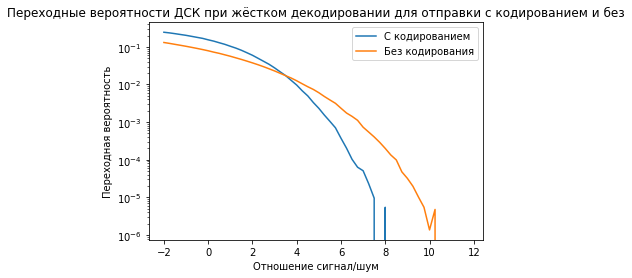

In [13]:
plt.figure()
plt.semilogy(snrs, hard_encode, label='С кодированием')
plt.semilogy(snrs, hard_no_encode, label='Без кодирования')
plt.legend(loc='upper right')
plt.title('Переходные вероятности ДСК при жёстком декодировании для отправки с кодированием и без')
plt.xlabel('Отношение сигнал/шум')
plt.ylabel('Переходная вероятность')
plt.show()

In [14]:
hard_encode.shape, hard_no_encode.shape, len(snrs)

((56,), (56,), 56)

In [15]:
dists = [] 
# разность между отношением сигнал/шум, необходимым для достижения заданной вероятности ошибок
# с кодированием и без
dist_ps = [] # заданные вероятности ошибок

for ind in range(len(snrs)):
    if hard_encode[ind] > 1e-9: # выбираем ненулевую вероятность ошибок при отправке с кодированием
        nearest_p_ind = np.argmin(abs(hard_no_encode - hard_encode[ind])) 
        # находим индекс ближайшей к ней вероятности ошибки при отправке без кодирования
        dists.append(snrs[nearest_p_ind] - snrs[ind]) # сохраняем разность между отношениями сигнал/шум
        dist_ps.append(hard_encode[ind]) # и заданную вероятность

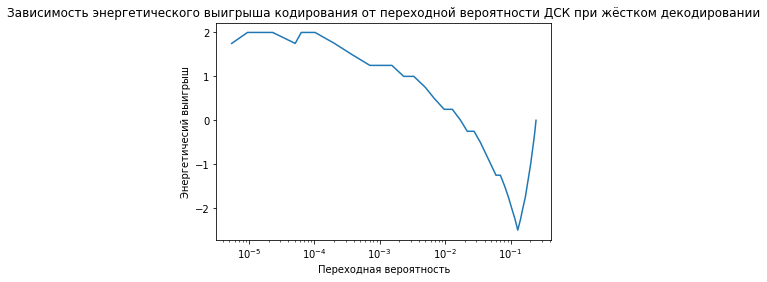

In [16]:
plt.semilogx(dist_ps, dists)
plt.title('Зависимость энергетического выигрыша кодирования от переходной вероятности ДСК при жёстком декодировании')
plt.xlabel('Переходная вероятность')
plt.ylabel('Энергетичесий выигрыш')
plt.show()